In [1]:
!pip install ultralytics tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [2]:
# ================================================================
# 0. Imports & global settings
# ================================================================
import shutil, yaml, time, random
from pathlib import Path
from collections import defaultdict

import matplotlib.pyplot as plt
from ultralytics import YOLO

random.seed(0)
total_start = time.time()

BASE_INPUT = Path('/kaggle/input')
DEST_ROOT  = Path('fire_dataset')      # detection dataset
CLS_ROOT   = Path('fire_cls')          # classification dataset

# ================================================================
# 1. PREPROCESS & COPY datasets  ➜ detection + classification
# ================================================================
print("=== Step 1: Preprocessing & copying datasets ===")
t0 = time.time()

datasets = [
    #      src-root                                             fire-class-ID  tag
    (BASE_INPUT/'fire-detection'/'Fire-Detection',              0,             'fire_only'),
    (BASE_INPUT/'firesmoke-detection-yolo-v9'/'Fire and Smoke Dataset', 0,     'fire_smoke'),
    (BASE_INPUT/'smoke-fire-detection-yolo',                    1,             'smoke_fire'),
]
splits_map = {'train':'train', 'valid':'val', 'val':'val', 'test':'test'}

SAMPLE_FRAC = 0.2        
random.seed(0)              # reproducible sampling

# prepare classifier folders (binary: background=0, fire=1)
for split in ['train', 'val', 'test']:
    (CLS_ROOT/split/'background').mkdir(parents=True, exist_ok=True)
    (CLS_ROOT/split/'fire').mkdir(parents=True, exist_ok=True)
# ================================================================
# 1. PREPROCESS & COPY datasets  ➜ detection + classification
#     *only 1 % of the images are kept per split*
# ================================================================

for src_root, fire_id, label in datasets:
    print(f"Processing dataset '{label}' …")
    for src_split, dst_split in splits_map.items():
        print(f"  · Split '{src_split}' → '{dst_split}'")

        # locate images / labels
        img_candidates = [src_root/src_split/'images', src_root/'data'/src_split/'images']
        lbl_candidates = [src_root/src_split/'labels', src_root/'data'/src_split/'labels']
        src_img = next((p for p in img_candidates if p.exists()), None)
        src_lbl = next((p for p in lbl_candidates if p.exists()), None)
        if not src_img:
            print("    ⚠  No images found – skipped.")
            continue

        # sample just 1 %  (at least one image)
        all_imgs   = list(src_img.glob('*.*'))
        k          = max(1, round(len(all_imgs) * SAMPLE_FRAC))
        sample_imgs = random.sample(all_imgs, k)
        print(f"    · Sampling {k}/{len(all_imgs)} images ({SAMPLE_FRAC*100:.1f} %)")

        # destination dirs for detection
        dst_img = DEST_ROOT/label/dst_split/'images'
        dst_lbl = DEST_ROOT/label/dst_split/'labels'
        dst_img.mkdir(parents=True, exist_ok=True)
        dst_lbl.mkdir(parents=True, exist_ok=True)

        copied = defaultdict(int)
        for img_path in sample_imgs:
            # ---------- copy to DETECTION dataset ----------
            shutil.copy(img_path, dst_img/img_path.name)
            txt_out = dst_lbl/f"{img_path.stem}.txt"

            has_fire_box = False
            if src_lbl:
                lbl_src = src_lbl/f"{img_path.stem}.txt"
                if lbl_src.exists():
                    kept = []
                    for ln in lbl_src.read_text().splitlines():
                        parts = ln.strip().split()
                        if parts and parts[0].isdigit() and int(parts[0]) == fire_id:
                            kept.append("0 " + " ".join(parts[1:]))
                            has_fire_box = True
                    txt_out.write_text("\n".join(kept))
            if not txt_out.exists():
                txt_out.write_text("")
            if txt_out.stat().st_size == 0:
                has_fire_box = False

            # ---------- copy to CLASSIFICATION dataset ----------
            cls_split_dir = CLS_ROOT/dst_split/('fire' if has_fire_box else 'background')
            shutil.copy(img_path, cls_split_dir/img_path.name)
            copied['fire' if has_fire_box else 'background'] += 1

        print(f"    → Copied {sum(copied.values()):4} imgs "
              f"(fire={copied['fire']}, bg={copied['background']}).")

print(f"Step 1 completed in {time.time() - t0:.1f}s\n")


# ================================================================
# 2. YAMLs  ➜ detection & classification
# ================================================================
print("=== Step 2: Writing YAML configs ===")
t1 = time.time()

data_det = {
    'train': [str(DEST_ROOT/label/'train'/'images') for *_, label in datasets],
    'val'  : [str(DEST_ROOT/label/'val'  /'images') for *_, label in datasets],
    'test' : [str(DEST_ROOT/label/'test' /'images') for *_, label in datasets],
    'nc': 1,
    'names': ['fire']
}
with open('data_fire.yaml','w') as f: yaml.dump(data_det, f, sort_keys=False)

data_cls = {
    'train': str(CLS_ROOT/'train'),
    'val'  : str(CLS_ROOT/'val'),
    'test' : str(CLS_ROOT/'test'),
    'nc'   : 2,
    'names': ['background','fire']
}
with open('data_fire_cls.yaml','w') as f: yaml.dump(data_cls, f, sort_keys=False)

print("data_fire.yaml:\n", yaml.dump(data_det, sort_keys=False))
print("data_fire_cls.yaml:\n", yaml.dump(data_cls, sort_keys=False))
print(f"Step 2 completed in {time.time() - t1:.1f}s\n")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
=== Step 1: Preprocessing & copying datasets ===
Processing dataset 'fire_only' …
  · Split 'train' → 'train'
    · Sampling 201/1004 images (20.0 %)
    → Copied  201 imgs (fire=201, bg=0).
  · Split 'valid' → 'val'
    · Sampling 151/754 images (20.0 %)
    → Copied  151 imgs (fire=151, bg=0).
  · Split 'val' → 'val'
    ⚠  No images found – skipped.
  · Split 'test' → 'test'
    · Sampling 150/751 images (20.0 %)
    → Copied  150 imgs (fire=149, bg=1).
Processing dataset 'fire_smoke' …
  · Split 'train' → 'train'
    · Sampling 7139/35695 images (20.0 %)
    → Copied 7139 imgs (fire=2759, bg=4380).
  · Split 'valid' → 'val'
    · Sampling 978/4892 images (20.0 %)
    → Copied 

In [3]:
# ================================================================
# 3. Train LIGHT-WEIGHT CLASSIFIER (stage-1)
# ================================================================
print("=== Step 3: Training YOLOv8-nano-CLS (stage-1) ===")
t2 = time.time()

model_cls = YOLO('yolov8n-cls.pt')
r_cls = model_cls.train(
    data=str(CLS_ROOT),            # ✅ point to the folder fire_cls/
    epochs=50,
    imgsz=224,
    batch=16,
    optimizer='Adam',
    lr0=1e-3,
    label_smoothing=0.05,
)

cls_best = Path(r_cls.save_dir)/'weights/best.pt'
shutil.copy(cls_best, 'fire_cls_best.pt')   # easy to download later
print(f"🏋️  Classifier best weight saved → fire_cls_best.pt")
print(f"Step 3 completed in {time.time() - t2:.1f}s\n")

=== Step 3: Training YOLOv8-nano-CLS (stage-1) ===


100%|██████████| 5.31M/5.31M [00:00<00:00, 71.7MB/s]


WARNING ⚠️ 'label_smoothing' is deprecated and will be removed in in the future.
Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=fire_cls, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=Adam, overlap_mask=True

100%|██████████| 5.35M/5.35M [00:00<00:00, 69.3MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 979.6±487.6 MB/s, size: 33.0 KB)


train: Scanning /kaggle/working/fire_cls/train... 10164 images, 0 corrupt: 100%|██████████| 10164/10164 [00:03<00:00, 2906.26it/s]

train: /kaggle/working/fire_cls/train/background/WEB02521.jpg: corrupt JPEG restored and saved
train: /kaggle/working/fire_cls/train/background/WEB07278.jpg: corrupt JPEG restored and saved
train: /kaggle/working/fire_cls/train/background/WEB07534.jpg: corrupt JPEG restored and saved
train: /kaggle/working/fire_cls/train/background/WEB07639.jpg: corrupt JPEG restored and saved
train: /kaggle/working/fire_cls/train/fire/WEB07541.jpg: corrupt JPEG restored and saved
train: /kaggle/working/fire_cls/train/fire/WEB07555.jpg: corrupt JPEG restored and saved
train: /kaggle/working/fire_cls/train/fire/WEB07557.jpg: corrupt JPEG restored and saved
train: New cache created: /kaggle/working/fire_cls/train.cache


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 419.5±179.4 MB/s, size: 15.7 KB)


val: Scanning /kaggle/working/fire_cls/val... 1749 images, 0 corrupt: 100%|██████████| 1749/1749 [00:00<00:00, 2876.24it/s]

val: /kaggle/working/fire_cls/val/fire/WEB07535.jpg: corrupt JPEG restored and saved


val: New cache created: /kaggle/working/fire_cls/val.cache
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/classify/train
Starting training for 50 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/50      0.25G      0.595         16        224:   1%|          | 5/636 [00:01<01:46,  5.91it/s]

       1/50      0.27G     0.5954         16        224:   1%|▏         | 9/636 [00:01<01:08,  9.13it/s]
100%|██████████| 755k/755k [00:00<00:00, 16.3MB/s]
               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:05<00:00,  9.39it/s]

                   all      0.907          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:05<00:00,  9.38it/s]

                   all      0.906          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:05<00:00,  9.42it/s]

                   all      0.913          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:05<00:00,  9.57it/s]

                   all      0.919          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:05<00:00,  9.67it/s]

                   all      0.933          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:05<00:00,  9.36it/s]

                   all      0.904          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:05<00:00,  9.25it/s]

                   all      0.921          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:06<00:00,  8.98it/s]

                   all       0.93          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:05<00:00,  9.28it/s]

                   all      0.922          1



      Epoch    GPU_mem       loss  Instances       Size


      10/50     0.346G     0.2225          4        224: 100%|██████████| 636/636 [00:46<00:00, 13.78it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:05<00:00,  9.58it/s]

                   all      0.919          1

      Epoch    GPU_mem       loss  Instances       Size



      11/50     0.355G     0.2199          4        224: 100%|██████████| 636/636 [00:45<00:00, 13.89it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:05<00:00,  9.53it/s]

                   all       0.93          1



      Epoch    GPU_mem       loss  Instances       Size


      12/50     0.363G     0.2141          4        224: 100%|██████████| 636/636 [00:45<00:00, 13.83it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:05<00:00,  9.27it/s]

                   all      0.937          1



      Epoch    GPU_mem       loss  Instances       Size


      13/50     0.371G     0.2134          4        224: 100%|██████████| 636/636 [00:44<00:00, 14.15it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:06<00:00,  8.92it/s]

                   all      0.925          1



      Epoch    GPU_mem       loss  Instances       Size


      14/50     0.379G     0.2152          4        224: 100%|██████████| 636/636 [00:45<00:00, 13.96it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:05<00:00,  9.63it/s]

                   all      0.924          1

      Epoch    GPU_mem       loss  Instances       Size



      15/50     0.387G     0.2062          4        224: 100%|██████████| 636/636 [00:45<00:00, 13.92it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:05<00:00,  9.35it/s]

                   all      0.934          1



      Epoch    GPU_mem       loss  Instances       Size


      16/50     0.396G     0.2018          4        224: 100%|██████████| 636/636 [00:44<00:00, 14.14it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:05<00:00,  9.47it/s]

                   all      0.941          1

      Epoch    GPU_mem       loss  Instances       Size



      17/50     0.404G     0.2007          4        224: 100%|██████████| 636/636 [00:45<00:00, 13.84it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:05<00:00,  9.64it/s]

                   all      0.934          1

      Epoch    GPU_mem       loss  Instances       Size



      18/50     0.412G     0.1964          4        224: 100%|██████████| 636/636 [00:45<00:00, 14.07it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:05<00:00,  9.19it/s]

                   all      0.923          1

      Epoch    GPU_mem       loss  Instances       Size



      19/50      0.42G     0.1951          4        224: 100%|██████████| 636/636 [00:45<00:00, 13.90it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:05<00:00,  9.78it/s]

                   all      0.938          1



      Epoch    GPU_mem       loss  Instances       Size


      20/50     0.428G     0.1888          4        224: 100%|██████████| 636/636 [00:46<00:00, 13.69it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:05<00:00,  9.56it/s]

                   all      0.935          1

      Epoch    GPU_mem       loss  Instances       Size



      21/50     0.436G     0.1843          4        224: 100%|██████████| 636/636 [00:45<00:00, 13.97it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:06<00:00,  8.79it/s]

                   all      0.919          1

      Epoch    GPU_mem       loss  Instances       Size



      22/50     0.443G     0.1762          4        224: 100%|██████████| 636/636 [00:45<00:00, 14.01it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:05<00:00,  9.19it/s]

                   all      0.938          1



      Epoch    GPU_mem       loss  Instances       Size


      23/50     0.453G     0.1861          4        224: 100%|██████████| 636/636 [00:46<00:00, 13.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:05<00:00,  9.22it/s]

                   all      0.931          1

      Epoch    GPU_mem       loss  Instances       Size



      24/50     0.461G     0.1732          4        224: 100%|██████████| 636/636 [00:45<00:00, 13.96it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:05<00:00,  9.69it/s]

                   all      0.931          1



      Epoch    GPU_mem       loss  Instances       Size


      25/50     0.469G     0.1703          4        224: 100%|██████████| 636/636 [00:46<00:00, 13.73it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:05<00:00,  9.27it/s]

                   all      0.941          1



      Epoch    GPU_mem       loss  Instances       Size


      26/50     0.477G     0.1669          4        224: 100%|██████████| 636/636 [00:45<00:00, 13.94it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:06<00:00,  8.76it/s]

                   all      0.927          1



      Epoch    GPU_mem       loss  Instances       Size


      27/50     0.484G     0.1721          4        224: 100%|██████████| 636/636 [00:45<00:00, 13.94it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:05<00:00,  9.49it/s]

                   all      0.938          1

      Epoch    GPU_mem       loss  Instances       Size



      28/50     0.492G     0.1536          4        224: 100%|██████████| 636/636 [00:45<00:00, 13.91it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:06<00:00,  9.04it/s]

                   all      0.937          1

      Epoch    GPU_mem       loss  Instances       Size



      29/50     0.502G     0.1636          4        224: 100%|██████████| 636/636 [00:44<00:00, 14.13it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:05<00:00,  9.84it/s]

                   all      0.937          1



      Epoch    GPU_mem       loss  Instances       Size


      30/50      0.51G     0.1546          4        224: 100%|██████████| 636/636 [00:46<00:00, 13.82it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:05<00:00,  9.66it/s]

                   all      0.938          1

      Epoch    GPU_mem       loss  Instances       Size



      31/50     0.518G     0.1488          4        224: 100%|██████████| 636/636 [00:45<00:00, 13.93it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:05<00:00,  9.67it/s]

                   all      0.938          1



      Epoch    GPU_mem       loss  Instances       Size


      32/50     0.525G     0.1536          4        224: 100%|██████████| 636/636 [00:45<00:00, 13.84it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:05<00:00,  9.73it/s]

                   all      0.941          1



      Epoch    GPU_mem       loss  Instances       Size


      33/50     0.535G     0.1466          4        224: 100%|██████████| 636/636 [00:46<00:00, 13.75it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:06<00:00,  8.95it/s]

                   all      0.933          1



      Epoch    GPU_mem       loss  Instances       Size


      34/50     0.541G     0.1438          4        224: 100%|██████████| 636/636 [00:45<00:00, 14.13it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:06<00:00,  8.87it/s]

                   all      0.938          1



      Epoch    GPU_mem       loss  Instances       Size


      35/50     0.551G     0.1381          4        224: 100%|██████████| 636/636 [00:45<00:00, 13.91it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:05<00:00,  9.67it/s]

                   all      0.942          1



      Epoch    GPU_mem       loss  Instances       Size


      36/50     0.559G     0.1342          4        224: 100%|██████████| 636/636 [00:45<00:00, 13.87it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:05<00:00,  9.57it/s]

                   all      0.934          1



      Epoch    GPU_mem       loss  Instances       Size


      37/50     0.566G     0.1377          4        224: 100%|██████████| 636/636 [00:45<00:00, 13.85it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:05<00:00,  9.41it/s]

                   all      0.931          1



      Epoch    GPU_mem       loss  Instances       Size


      38/50     0.576G     0.1354          4        224: 100%|██████████| 636/636 [00:46<00:00, 13.76it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:06<00:00,  8.61it/s]

                   all      0.931          1



      Epoch    GPU_mem       loss  Instances       Size


      39/50     0.582G     0.1284          4        224: 100%|██████████| 636/636 [00:45<00:00, 13.95it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:05<00:00,  9.48it/s]

                   all      0.938          1



      Epoch    GPU_mem       loss  Instances       Size


      40/50     0.592G     0.1252          4        224: 100%|██████████| 636/636 [00:45<00:00, 13.85it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:05<00:00,  9.82it/s]

                   all      0.939          1



      Epoch    GPU_mem       loss  Instances       Size


      41/50       0.6G     0.1191          4        224: 100%|██████████| 636/636 [00:46<00:00, 13.73it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:05<00:00,  9.59it/s]

                   all       0.94          1



      Epoch    GPU_mem       loss  Instances       Size


      42/50     0.607G     0.1179          4        224: 100%|██████████| 636/636 [00:45<00:00, 13.90it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:06<00:00,  8.85it/s]

                   all      0.941          1



      Epoch    GPU_mem       loss  Instances       Size


      43/50     0.615G     0.1139          4        224: 100%|██████████| 636/636 [00:45<00:00, 14.09it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:05<00:00,  9.62it/s]

                   all      0.942          1



      Epoch    GPU_mem       loss  Instances       Size


      44/50     0.623G     0.1144          4        224: 100%|██████████| 636/636 [00:46<00:00, 13.77it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:05<00:00,  9.85it/s]

                   all      0.943          1

      Epoch    GPU_mem       loss  Instances       Size



      45/50     0.631G     0.1135          4        224: 100%|██████████| 636/636 [00:44<00:00, 14.16it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:06<00:00,  8.84it/s]

                   all      0.945          1



      Epoch    GPU_mem       loss  Instances       Size


      46/50     0.641G     0.1097          4        224: 100%|██████████| 636/636 [00:45<00:00, 13.97it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:05<00:00,  9.82it/s]

                   all       0.95          1



      Epoch    GPU_mem       loss  Instances       Size


      47/50     0.648G    0.09925          4        224: 100%|██████████| 636/636 [00:45<00:00, 13.94it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:06<00:00,  7.88it/s]

                   all      0.945          1



      Epoch    GPU_mem       loss  Instances       Size


      48/50     0.656G     0.1048          4        224: 100%|██████████| 636/636 [00:45<00:00, 14.00it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:05<00:00,  9.45it/s]

                   all      0.949          1



      Epoch    GPU_mem       loss  Instances       Size


      49/50     0.664G    0.09774          4        224: 100%|██████████| 636/636 [00:46<00:00, 13.63it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:05<00:00,  9.41it/s]

                   all      0.945          1



      Epoch    GPU_mem       loss  Instances       Size


      50/50     0.672G     0.1006          4        224: 100%|██████████| 636/636 [00:45<00:00, 14.05it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:06<00:00,  9.04it/s]

                   all      0.945          1

50 epochs completed in 0.720 hours.


Optimizer stripped from runs/classify/train/weights/last.pt, 3.0MB
Optimizer stripped from runs/classify/train/weights/best.pt, 3.0MB

Validating runs/classify/train/weights/best.pt...
Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-cls summary (fused): 30 layers, 1,437,442 parameters, 0 gradients, 3.3 GFLOPs
train: /kaggle/working/fire_cls/train... found 10164 images in 2 classes ✅ 
val: /kaggle/working/fire_cls/val... found 1749 images in 2 classes ✅ 
test: /kaggle/working/fire_cls/test... found 1462 images in 2 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 55/55 [00:05<00:00,  9.45it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       0.95          1
Speed: 0.1ms preprocess, 0.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train
🏋️  Classifier best weight saved → fire_cls_best.pt
Step 3 completed in 2622.9s



In [4]:
print("=== Step 4: Training YOLOv8-nano DETECTOR (stage-2) ===")
t3 = time.time()

model_det = YOLO('yolov8n.pt')
r_det = model_det.train(
    data='data_fire.yaml',
    epochs=80,
    imgsz=320,
    batch=8,
    optimizer='Adam',
    lr0=1e-3,
    freeze=[0,1],
    mosaic=0.2,
    mixup=0.1,
    hsv_h=0.01, hsv_s=0.4, hsv_v=0.3,
)

det_best = Path(r_det.save_dir)/'weights/best.pt'
shutil.copy(det_best, 'fire_det_best.pt')
print(f"Detector best weight saved → fire_det_best.pt")
print(f"Step 4 completed in {time.time() - t3:.1f}s\n")
# (optional) export to ONNX for edge devices
print("=== Exporting both stages to ONNX (optional) ===")
model_cls.export(format='onnx', imgsz=224, simplify=True)
model_det.export(format='onnx', imgsz=320, simplify=True)
print("    → fire_cls_best.onnx, fire_det_best.onnx\n")

=== Step 4: Training YOLOv8-nano DETECTOR (stage-2) ===


100%|██████████| 6.25M/6.25M [00:00<00:00, 82.2MB/s]

Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data_fire.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=80, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=[0, 1], half=False, hsv_h=0.01, hsv_s=0.4, hsv_v=0.3, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=0.2, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=Adam, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profil

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/working/fire_dataset/fire_only/train/labels... 10164 images, 6445 backgrounds, 0 corrupt: 100%|██████████| 10164/10164 [00:05<00:00, 1799.00it/s]

train: /kaggle/working/fire_dataset/smoke_fire/train/images/WEB02521.jpg: corrupt JPEG restored and saved
train: /kaggle/working/fire_dataset/smoke_fire/train/images/WEB07278.jpg: corrupt JPEG restored and saved
train: /kaggle/working/fire_dataset/smoke_fire/train/images/WEB07534.jpg: corrupt JPEG restored and saved
train: /kaggle/working/fire_dataset/smoke_fire/train/images/WEB07541.jpg: corrupt JPEG restored and saved
train: /kaggle/working/fire_dataset/smoke_fire/train/images/WEB07555.jpg: corrupt JPEG restored and saved
train: /kaggle/working/fire_dataset/smoke_fire/train/images/WEB07557.jpg: corrupt JPEG restored and saved
train: /kaggle/working/fire_dataset/smoke_fire/train/images/WEB07639.jpg: corrupt JPEG restored and saved


train: New cache created: /kaggle/working/fire_dataset/fire_only/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 261.2±111.6 MB/s, size: 36.7 KB)


val: Scanning /kaggle/working/fire_dataset/fire_only/val/labels... 1749 images, 752 backgrounds, 0 corrupt: 100%|██████████| 1749/1749 [00:01<00:00, 1556.15it/s]

val: /kaggle/working/fire_dataset/smoke_fire/val/images/WEB07535.jpg: corrupt JPEG restored and saved
val: New cache created: /kaggle/working/fire_dataset/fire_only/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 80 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/80     0.426G      2.211      2.836      1.805          3        320: 100%|██████████| 1271/1271 [01:39<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:08<00:00, 13.09it/s]

                   all       1749       1640      0.269      0.241      0.187      0.069



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/80     0.426G      2.219      2.592       1.82          3        320: 100%|██████████| 1271/1271 [01:30<00:00, 14.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.35it/s]

                   all       1749       1640      0.333      0.271       0.22     0.0858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/80     0.426G      2.143      2.451      1.728          5        320: 100%|██████████| 1271/1271 [01:28<00:00, 14.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.04it/s]


                   all       1749       1640       0.32      0.363      0.238     0.0966

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/80     0.426G      2.105      2.433      1.721          0        320: 100%|██████████| 1271/1271 [01:28<00:00, 14.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.18it/s]


                   all       1749       1640      0.436      0.354      0.332      0.141

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/80     0.434G      2.064      2.337      1.674          2        320: 100%|██████████| 1271/1271 [01:27<00:00, 14.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 14.31it/s]

                   all       1749       1640      0.425        0.4      0.347      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/80     0.451G      2.044      2.247       1.68          1        320: 100%|██████████| 1271/1271 [01:27<00:00, 14.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 14.70it/s]


                   all       1749       1640      0.459      0.385      0.328      0.148

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/80     0.469G       1.99      2.244      1.637          7        320: 100%|██████████| 1271/1271 [01:27<00:00, 14.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.27it/s]


                   all       1749       1640      0.497      0.416      0.383      0.167

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/80     0.484G      1.981      2.201       1.65          1        320: 100%|██████████| 1271/1271 [01:28<00:00, 14.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.20it/s]


                   all       1749       1640       0.48      0.423      0.392      0.169

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/80     0.502G      1.955      2.118      1.619          2        320: 100%|██████████| 1271/1271 [01:28<00:00, 14.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.11it/s]


                   all       1749       1640      0.486      0.457      0.429      0.189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/80      0.52G      1.955      2.099      1.622          6        320: 100%|██████████| 1271/1271 [01:28<00:00, 14.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.61it/s]


                   all       1749       1640      0.479      0.427      0.403      0.178

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/80     0.537G      1.935      2.103      1.612          4        320: 100%|██████████| 1271/1271 [01:27<00:00, 14.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 14.64it/s]


                   all       1749       1640      0.518      0.406      0.412      0.183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/80     0.553G      1.916      2.064      1.593          1        320: 100%|██████████| 1271/1271 [01:27<00:00, 14.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.65it/s]

                   all       1749       1640       0.55      0.462      0.457      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/80      0.57G        1.9      2.033      1.584          4        320: 100%|██████████| 1271/1271 [01:28<00:00, 14.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.45it/s]


                   all       1749       1640      0.548       0.45      0.467      0.209

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/80     0.588G      1.876      2.039       1.59          4        320: 100%|██████████| 1271/1271 [01:27<00:00, 14.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.07it/s]


                   all       1749       1640      0.574      0.425      0.468      0.204

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/80     0.604G       1.86      1.955      1.567          3        320: 100%|██████████| 1271/1271 [01:26<00:00, 14.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.41it/s]


                   all       1749       1640      0.596      0.439      0.488      0.219

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/80     0.621G      1.896      1.984      1.593          3        320: 100%|██████████| 1271/1271 [01:28<00:00, 14.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.37it/s]

                   all       1749       1640      0.579      0.468      0.463      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/80     0.639G      1.883      1.939      1.564          2        320: 100%|██████████| 1271/1271 [01:27<00:00, 14.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 14.94it/s]

                   all       1749       1640      0.587      0.471      0.499       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/80     0.654G      1.868      1.929      1.567          4        320: 100%|██████████| 1271/1271 [01:27<00:00, 14.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 14.06it/s]

                   all       1749       1640       0.55      0.471      0.462      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/80     0.672G      1.847      1.933      1.558          5        320: 100%|██████████| 1271/1271 [01:26<00:00, 14.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.53it/s]


                   all       1749       1640      0.603      0.476      0.523       0.24

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/80     0.689G      1.824      1.944      1.548          2        320: 100%|██████████| 1271/1271 [01:28<00:00, 14.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.65it/s]


                   all       1749       1640      0.549      0.482      0.464       0.21

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/80     0.707G      1.832        1.9      1.549          1        320: 100%|██████████| 1271/1271 [01:28<00:00, 14.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 13.89it/s]


                   all       1749       1640      0.594      0.455      0.494      0.226

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/80     0.723G      1.825      1.945      1.561          4        320: 100%|██████████| 1271/1271 [01:27<00:00, 14.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.36it/s]

                   all       1749       1640      0.619      0.479      0.527      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/80      0.74G      1.795      1.827      1.522          5        320: 100%|██████████| 1271/1271 [01:28<00:00, 14.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.56it/s]


                   all       1749       1640      0.639      0.507       0.55      0.255

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/80     0.758G      1.786       1.86      1.522          1        320: 100%|██████████| 1271/1271 [01:27<00:00, 14.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 14.00it/s]

                   all       1749       1640      0.638      0.495       0.54      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/80     0.773G        1.8      1.841      1.526          1        320: 100%|██████████| 1271/1271 [01:27<00:00, 14.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.34it/s]

                   all       1749       1640      0.623      0.498      0.537      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/80     0.791G      1.804      1.824      1.521          1        320: 100%|██████████| 1271/1271 [01:28<00:00, 14.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.34it/s]

                   all       1749       1640      0.624      0.497      0.548      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/80     0.809G      1.777      1.838       1.52          2        320: 100%|██████████| 1271/1271 [01:27<00:00, 14.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 14.39it/s]


                   all       1749       1640      0.666      0.489      0.551      0.261

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/80     0.824G       1.78      1.841      1.523          4        320: 100%|██████████| 1271/1271 [01:27<00:00, 14.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.54it/s]

                   all       1749       1640      0.618      0.515      0.552      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/80     0.844G      1.787      1.808       1.53          8        320: 100%|██████████| 1271/1271 [01:28<00:00, 14.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.11it/s]


                   all       1749       1640      0.646      0.512      0.559      0.275

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/80     0.859G      1.782      1.791      1.527         10        320: 100%|██████████| 1271/1271 [01:28<00:00, 14.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.64it/s]


                   all       1749       1640      0.667      0.501      0.568      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/80     0.877G      1.778      1.771      1.517          1        320: 100%|██████████| 1271/1271 [01:27<00:00, 14.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.32it/s]


                   all       1749       1640      0.624      0.507      0.561       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/80     0.893G      1.793      1.806      1.525          4        320: 100%|██████████| 1271/1271 [01:26<00:00, 14.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.56it/s]

                   all       1749       1640      0.621       0.51       0.56      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/80      0.91G      1.756      1.773       1.51          1        320: 100%|██████████| 1271/1271 [01:27<00:00, 14.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.63it/s]


                   all       1749       1640      0.647      0.506      0.561      0.272

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/80     0.928G      1.751      1.765      1.496          6        320: 100%|██████████| 1271/1271 [01:26<00:00, 14.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:06<00:00, 15.75it/s]


                   all       1749       1640      0.657      0.512      0.564       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/80     0.943G       1.77      1.773      1.515          4        320: 100%|██████████| 1271/1271 [01:26<00:00, 14.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.48it/s]

                   all       1749       1640      0.641      0.523      0.575      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/80     0.961G       1.77      1.742      1.506          0        320: 100%|██████████| 1271/1271 [01:27<00:00, 14.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.24it/s]


                   all       1749       1640      0.648      0.504      0.573      0.285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/80     0.979G      1.741      1.746      1.498          0        320: 100%|██████████| 1271/1271 [01:27<00:00, 14.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.59it/s]


                   all       1749       1640      0.633      0.526       0.58      0.285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/80     0.996G       1.75      1.714      1.491          1        320: 100%|██████████| 1271/1271 [01:27<00:00, 14.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 14.83it/s]


                   all       1749       1640      0.672      0.512      0.585      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/80      1.01G      1.726      1.711      1.479          1        320: 100%|██████████| 1271/1271 [01:26<00:00, 14.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.43it/s]

                   all       1749       1640      0.663      0.527      0.599      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/80      1.03G      1.744      1.713      1.487          2        320: 100%|██████████| 1271/1271 [01:27<00:00, 14.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.40it/s]


                   all       1749       1640      0.663      0.528      0.599      0.296

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/80      1.05G      1.721      1.705      1.477          5        320: 100%|██████████| 1271/1271 [01:28<00:00, 14.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.36it/s]


                   all       1749       1640       0.64      0.535      0.595      0.292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/80      1.06G      1.724      1.684      1.493          1        320: 100%|██████████| 1271/1271 [01:26<00:00, 14.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.49it/s]

                   all       1749       1640      0.642      0.535      0.589      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/80      1.08G      1.728      1.662      1.477          2        320: 100%|██████████| 1271/1271 [01:27<00:00, 14.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 13.76it/s]

                   all       1749       1640      0.646      0.541      0.594      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/80       1.1G      1.718      1.678      1.473          2        320: 100%|██████████| 1271/1271 [01:27<00:00, 14.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.06it/s]

                   all       1749       1640       0.68      0.528      0.605      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/80      1.12G      1.712      1.655       1.47          2        320: 100%|██████████| 1271/1271 [01:27<00:00, 14.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.39it/s]

                   all       1749       1640      0.673      0.553      0.609      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/80      1.13G      1.714       1.67      1.467          2        320: 100%|██████████| 1271/1271 [01:28<00:00, 14.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.47it/s]

                   all       1749       1640      0.655      0.538        0.6        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/80      1.15G      1.683      1.627      1.459          1        320: 100%|██████████| 1271/1271 [01:27<00:00, 14.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:06<00:00, 15.87it/s]

                   all       1749       1640      0.681       0.52      0.596      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/80      1.17G      1.671       1.64      1.447          2        320: 100%|██████████| 1271/1271 [01:26<00:00, 14.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.25it/s]

                   all       1749       1640      0.678      0.552      0.605      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/80      1.18G      1.678      1.644      1.468          2        320: 100%|██████████| 1271/1271 [01:27<00:00, 14.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.65it/s]


                   all       1749       1640      0.713       0.53       0.61      0.304

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/80       1.2G      1.659      1.597      1.446          5        320: 100%|██████████| 1271/1271 [01:26<00:00, 14.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.41it/s]


                   all       1749       1640      0.678      0.558      0.611      0.299

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/80      1.22G      1.679      1.611      1.449          6        320: 100%|██████████| 1271/1271 [01:26<00:00, 14.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:08<00:00, 13.71it/s]


                   all       1749       1640       0.69       0.54      0.611      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/80      1.23G      1.659      1.623       1.43          3        320: 100%|██████████| 1271/1271 [01:25<00:00, 14.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.54it/s]


                   all       1749       1640      0.703      0.535      0.622      0.306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/80      1.25G       1.67      1.595       1.43          8        320: 100%|██████████| 1271/1271 [01:26<00:00, 14.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.61it/s]

                   all       1749       1640      0.673      0.551      0.617      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/80      1.27G      1.643      1.587      1.424          1        320: 100%|██████████| 1271/1271 [01:27<00:00, 14.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 14.48it/s]

                   all       1749       1640      0.676      0.552      0.618       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/80      1.28G      1.641      1.565      1.429          0        320: 100%|██████████| 1271/1271 [01:27<00:00, 14.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.60it/s]

                   all       1749       1640      0.675      0.553      0.619       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/80       1.3G      1.636      1.544      1.423          2        320: 100%|██████████| 1271/1271 [01:28<00:00, 14.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.50it/s]

                   all       1749       1640      0.672      0.559      0.624      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/80      1.32G      1.655      1.558      1.434          1        320: 100%|██████████| 1271/1271 [01:29<00:00, 14.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.38it/s]


                   all       1749       1640      0.688      0.544      0.624      0.313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/80      1.34G      1.634      1.559      1.422          9        320: 100%|██████████| 1271/1271 [01:26<00:00, 14.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.51it/s]


                   all       1749       1640      0.711      0.545       0.63      0.313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/80      1.35G      1.642       1.55      1.422          6        320: 100%|██████████| 1271/1271 [01:26<00:00, 14.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.65it/s]

                   all       1749       1640      0.673      0.577      0.636      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/80      1.37G      1.618      1.549      1.413          4        320: 100%|██████████| 1271/1271 [01:28<00:00, 14.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.49it/s]


                   all       1749       1640       0.66      0.584      0.635      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/80      1.39G      1.616      1.528      1.422          4        320: 100%|██████████| 1271/1271 [01:26<00:00, 14.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.46it/s]


                   all       1749       1640      0.675      0.567      0.634      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/80       1.4G      1.598      1.509        1.4          0        320: 100%|██████████| 1271/1271 [01:26<00:00, 14.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:06<00:00, 15.74it/s]


                   all       1749       1640      0.691      0.559      0.631      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/80      1.42G      1.617      1.516      1.408          0        320: 100%|██████████| 1271/1271 [01:27<00:00, 14.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:06<00:00, 15.76it/s]


                   all       1749       1640      0.689      0.553      0.631      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/80      1.44G      1.634       1.54      1.414          3        320: 100%|██████████| 1271/1271 [01:26<00:00, 14.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.69it/s]

                   all       1749       1640      0.708      0.546      0.634       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/80      1.46G      1.576      1.469       1.39          5        320: 100%|██████████| 1271/1271 [01:26<00:00, 14.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:06<00:00, 15.73it/s]

                   all       1749       1640      0.688       0.57      0.638      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/80      1.47G      1.599      1.485      1.392          8        320: 100%|██████████| 1271/1271 [01:28<00:00, 14.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.30it/s]


                   all       1749       1640       0.71      0.553      0.641      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/80      1.49G      1.575      1.461      1.379          0        320: 100%|██████████| 1271/1271 [01:26<00:00, 14.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:06<00:00, 15.92it/s]


                   all       1749       1640      0.719      0.557      0.641      0.324

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/80      1.51G      1.601      1.475        1.4          1        320: 100%|██████████| 1271/1271 [01:26<00:00, 14.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.69it/s]

                   all       1749       1640      0.696      0.562      0.643      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/80      1.52G      1.583      1.476      1.394          5        320: 100%|██████████| 1271/1271 [01:27<00:00, 14.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 14.68it/s]


                   all       1749       1640      0.705      0.563      0.646      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/80      1.54G      1.592      1.449      1.391          1        320: 100%|██████████| 1271/1271 [01:26<00:00, 14.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:06<00:00, 15.82it/s]

                   all       1749       1640       0.72      0.554      0.641      0.326


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      71/80      1.56G      1.496      1.323      1.315          0        320: 100%|██████████| 1271/1271 [01:27<00:00, 14.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.24it/s]


                   all       1749       1640      0.709      0.559      0.641      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      72/80      1.57G      1.489      1.294      1.307          0        320: 100%|██████████| 1271/1271 [01:25<00:00, 14.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:08<00:00, 12.99it/s]

                   all       1749       1640      0.698      0.566      0.644      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      73/80      1.59G      1.485      1.305      1.317          1        320: 100%|██████████| 1271/1271 [01:24<00:00, 14.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.08it/s]


                   all       1749       1640      0.691      0.563      0.644      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      74/80      1.61G      1.479      1.273      1.313          3        320: 100%|██████████| 1271/1271 [01:24<00:00, 15.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.16it/s]


                   all       1749       1640      0.719      0.548      0.645      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      75/80      1.62G      1.474      1.267      1.287          3        320: 100%|██████████| 1271/1271 [01:24<00:00, 15.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:06<00:00, 15.75it/s]

                   all       1749       1640      0.715      0.553      0.649      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      76/80      1.64G      1.469      1.253      1.312          9        320: 100%|██████████| 1271/1271 [01:26<00:00, 14.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.47it/s]

                   all       1749       1640      0.727      0.545      0.647       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      77/80      1.66G       1.45      1.265      1.298          4        320: 100%|██████████| 1271/1271 [01:25<00:00, 14.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:06<00:00, 15.79it/s]

                   all       1749       1640      0.741      0.539      0.648      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      78/80      1.68G      1.463      1.272      1.309          2        320: 100%|██████████| 1271/1271 [01:25<00:00, 14.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.50it/s]


                   all       1749       1640      0.711      0.551      0.646      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      79/80      1.69G      1.472      1.244      1.299          1        320: 100%|██████████| 1271/1271 [01:25<00:00, 14.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 13.89it/s]

                   all       1749       1640      0.716      0.556      0.648      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      80/80      1.71G      1.459      1.242       1.29          1        320: 100%|██████████| 1271/1271 [01:26<00:00, 14.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:07<00:00, 15.56it/s]


                   all       1749       1640      0.722      0.552      0.648      0.328

80 epochs completed in 2.110 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [00:06<00:00, 16.69it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1749       1640      0.738      0.539      0.648       0.33
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/train
Detector best weight saved → fire_det_best.pt
Step 4 completed in 7629.3s

=== Exporting both stages to ONNX (optional) ===
Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
YOLOv8n-cls summary (fused): 30 layers, 1,437,442 parameters, 0 gradients, 3.3 GFLOPs

PyTorch: starting from 'runs/classify/train/weights/best.pt' with input shape (1, 3, 224, 224) BCHW and output shape(s) (1, 2) (2.8 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<1.18.0', 'onnxslim>=0.1.59', 'onnxruntime-gpu'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 14.9s
WARNING ⚠️ requirements: Restart runtime or 

=== Step 5: Two-stage inference demo ===
[CLS] ATragicDayFireStormMannford440_png.rf.ecabc1d2c972b560bb0206bd591a3893.jpg  fire=1.00  -> PASS


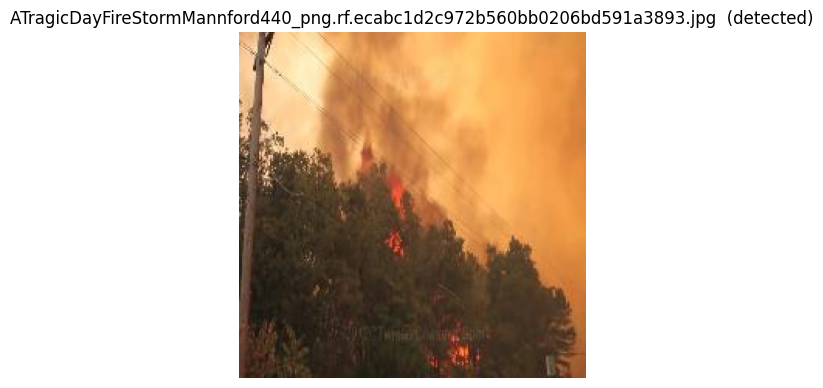

[CLS] Img_25958_jpg.rf.e1e4b5e7aed302100736d68f398b7604.jpg  fire=1.00  -> PASS


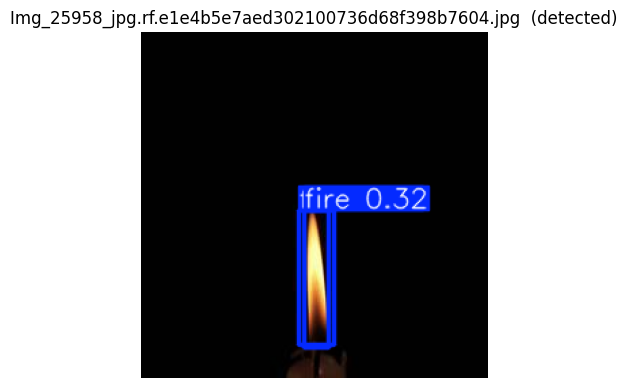

[CLS] CarThree64_png.rf.f9a598c5c5b3bb34c71d41e0bc3f1a9e.jpg  fire=1.00  -> PASS


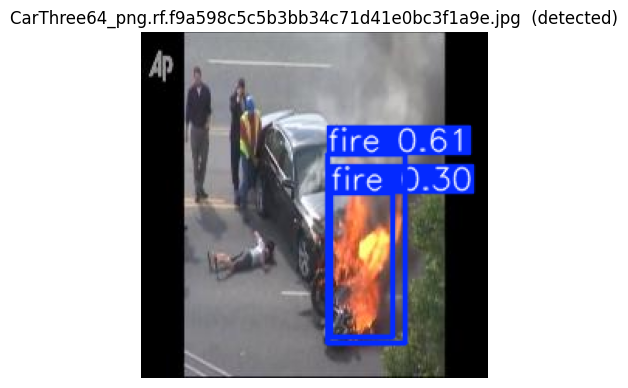

[CLS] Img_6901_jpg.rf.1c8b1db303f64d1b6a29247ccf619808.jpg  fire=0.95  -> PASS


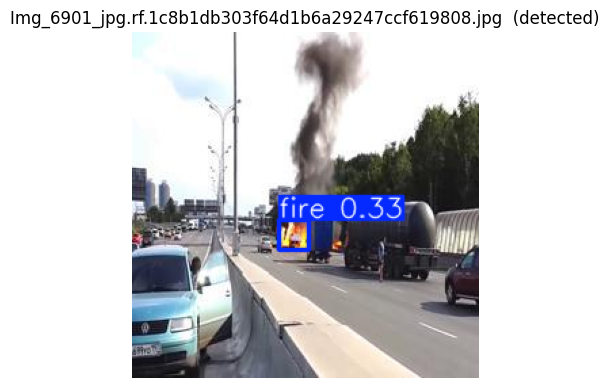

[CLS] Img_6977_jpg.rf.be41620adcd56e29d563ae777cc3b79e.jpg  fire=1.00  -> PASS


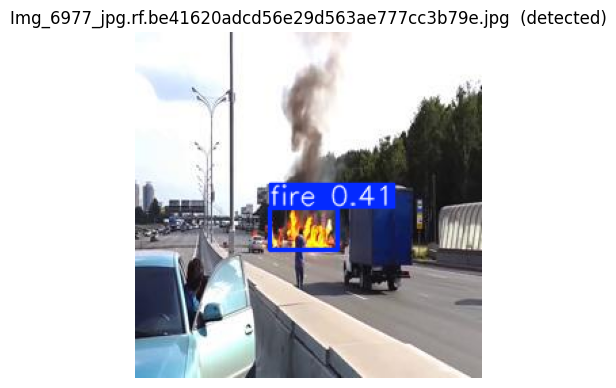


Stage-1 processed 5 imgs, Stage-2 processed 5 imgs.
Step 5 completed in 0.8s
Total wall time: 10529.1s


In [5]:
# ================================================================
# 5. Two-stage VISUALISATION on test set
# ================================================================
print("=== Step 5: Two-stage inference demo ===")
t4 = time.time()

THRESH = 0.50   # confidence threshold for stage-1
stage1_imgs   = 0
stage2_imgs   = 0

for img_dir in Path(data_det['test'][0]).parent.rglob('images'):
    for img_path in random.sample(list(img_dir.glob('*.[jp][pn]g')), k=min(5,len(list(img_dir.glob('*.[jp][pn]g'))))):
        stage1_imgs += 1
        # -------- Stage-1: image-level classification ----------
        cls_res = model_cls.predict(str(img_path), imgsz=224, verbose=False)
        conf_fire = float(cls_res[0].probs.data[1])      # index 1 == 'fire'
        is_fire = conf_fire >= THRESH
        print(f"[CLS] {img_path.name:25}  fire={conf_fire:.2f}  -> {'PASS' if is_fire else 'SKIP'}")

        if not is_fire:
            # Visualise skipped image
            plt.figure(figsize=(4,4)); plt.imshow(plt.imread(img_path))
            plt.title(f"{img_path.name}  (no-fire)")
            plt.axis('off'); plt.show()
            continue

        # -------- Stage-2: run detector only on fire-likely frames ----------
        stage2_imgs += 1
        det_res = model_det.predict(str(img_path), conf=0.25, imgsz=320, verbose=False)
        annotated = det_res[0].plot()

        plt.figure(figsize=(4.5,4.5))
        plt.imshow(annotated[:,:,::-1])
        plt.title(f"{img_path.name}  (detected)")
        plt.axis('off')
        plt.show()

print(f"\nStage-1 processed {stage1_imgs} imgs, Stage-2 processed {stage2_imgs} imgs.")
print(f"Step 5 completed in {time.time() - t4:.1f}s")
print(f"Total wall time: {time.time() - total_start:.1f}s")

In [6]:
# ================================================================
# Fire-spread ML + LSTM pipeline
# ================================================================

# 0. Imports & settings -----------------------------------------
import sys, json, math, time, shutil, itertools
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from ultralytics import YOLO
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

SEED         = 42
SEQ_LEN      = 5               # frames per sequence for LSTM
IMG_SIZE_YOLO= 320              # should match detector training
AREA_THRESH  = (0.02, 0.15)     # (incipient, developed, critical) thresholds
DEVICE       = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(SEED)
np.random.seed(SEED)

# 1. Collect image paths ----------------------------------------
import yaml   # add this with the other imports
# ---------------------------------------------------------------
# 1. Collect image paths  (train / val / test only)
# ---------------------------------------------------------------
det_yaml = yaml.safe_load(Path('data_fire.yaml').read_text())

splits = {}
for split in ('train', 'val', 'test'):
    paths = det_yaml.get(split, [])
    # normalise to list[str]
    if isinstance(paths, str):
        paths = [paths]
    elif not isinstance(paths, (list, tuple)):
        continue
    img_files = []
    for p in paths:
        p = Path(p)
        img_files += list(p.rglob('*.jpg')) + list(p.rglob('*.png'))
    splits[split] = img_files

print({k: len(v) for k, v in splits.items()})

# 2. Run detector → extract frame-wise features -----------------
det_model = YOLO('fire_det_best.pt')
FEATURES_CACHE = Path('fire_frame_feats.csv')

if not FEATURES_CACHE.exists():       # run only once – 3 GHz GPU ≈ 6 fps
    rows = []
    for split, img_paths in splits.items():
        for img_path in img_paths:
            res = det_model.predict(str(img_path), conf=0.25,
                                     imgsz=IMG_SIZE_YOLO, verbose=False)[0]
            h, w = res.orig_shape
            fire_boxes = [b for b,cls in zip(res.boxes.xyxy.cpu().numpy(),
                                             res.boxes.cls.cpu().numpy()) if cls==0]
            if fire_boxes:
                # choose largest box
                x1,y1,x2,y2 = max(fire_boxes, key=lambda b:(b[2]-b[0])*(b[3]-b[1]))
                area  = (x2-x1)*(y2-y1)
                cx,cy = (x1+x2)/2, (y1+y2)/2
                ar    = (x2-x1)/(y2-y1+1e-6)
            else:                       # no fire box
                area = cx = cy = ar = 0.0
            rows.append(dict(split=split,
                             file=str(img_path),
                             W=w, H=h,
                             area_px=area,
                             area_norm=area/(w*h),
                             cx_norm=cx/w,
                             cy_norm=cy/h,
                             asp_ratio=ar))
    pd.DataFrame(rows).to_csv(FEATURES_CACHE, index=False)

frame_df = pd.read_csv(FEATURES_CACHE)
print(frame_df.head())

# 3. Build sequences --------------------------------------------
# 3. Build sequences --------------------------------------------
def group_key(p: Path):
    # ✅  use parent folder as scene id
    #     e.g. …/fire_only/train/images/ ---> that whole folder
    return str(p.parent)

seq_map = defaultdict(list)
for _, row in frame_df.iterrows():
    gid = (row['split'], group_key(Path(row['file'])))
    seq_map[gid].append(row)


seq_rows = []
for (split,gid), frames in seq_map.items():
    frames = sorted(frames, key=lambda r: r['file'])
    # slide a window of length SEQ_LEN (stride = 1 for max data)
    for i in range(0, max(1,len(frames)-SEQ_LEN+1)):
        window = frames[i:i+SEQ_LEN]
        # skip if window is shorter than SEQ_LEN
        if len(window) < SEQ_LEN: continue
        fmat = np.array([[r['area_norm'], r['cx_norm'], r['cy_norm'], r['asp_ratio']]
                         for r in window], dtype=np.float32)
        final_area = window[-1]['area_norm']
        if   final_area < AREA_THRESH[0]:  label = 0          # incipient
        elif final_area < AREA_THRESH[1]:  label = 1          # developed
        else:                              label = 2          # critical
        seq_rows.append(dict(split=split, data=fmat, label=label))
print(f"Total sequences: {len(seq_rows)} (train={sum(r['split']=='train' for r in seq_rows)})")

# 4. Torch Dataset ----------------------------------------------
class FireSeqDS(Dataset):
    def __init__(self, rows):
        self.X = np.stack([r['data'] for r in rows])
        self.y = np.array([r['label'] for r in rows])
    def __len__(self):  return len(self.X)
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

train_rows = [r for r in seq_rows if r['split']=='train']
val_rows   = [r for r in seq_rows if r['split']=='val']
test_rows  = [r for r in seq_rows if r['split']=='test']

ds_train, ds_val, ds_test = FireSeqDS(train_rows), FireSeqDS(val_rows), FireSeqDS(test_rows)

# 5-A. Classical baseline (XGBoost on last-frame features) ------
X_train = ds_train.X[:,-1,:]        # take features of last frame only
X_val   = ds_val  .X[:,-1,:]
X_test  = ds_test .X[:,-1,:]
pipe = Pipeline([('scaler', StandardScaler()),
                 ('xgb',    XGBClassifier(
                     n_estimators=200, max_depth=4,
                     learning_rate=0.05, subsample=0.8,
                     objective='multi:softprob',
                     num_class=3, random_state=SEED))]
               )
pipe.fit(X_train, ds_train.y)
pred_test_ml = pipe.predict(X_test)
print("\n=== XGBoost RESULTS ===")
print(classification_report(ds_test.y, pred_test_ml, digits=3))

# 5-B. LSTM model ----------------------------------------------
class SpreadLSTM(nn.Module):
    def __init__(self, d_in=4, d_hid=64, n_cls=3):
        super().__init__()
        self.lstm = nn.LSTM(d_in, d_hid, num_layers=2,
                            dropout=0.2, batch_first=True)
        self.fc = nn.Linear(d_hid, n_cls)
    def forward(self, x):
        _, (h, _) = self.lstm(x)
        return self.fc(h[-1])

model = SpreadLSTM().to(DEVICE)
opt   = torch.optim.Adam(model.parameters(), lr=1e-3)
crit  = nn.CrossEntropyLoss()

def run_epoch(loader, train=True):
    if train: model.train()
    else:     model.eval()
    all_y, all_p = [], []
    loss_accum = 0
    for X,y in loader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        out  = model(X)
        loss = crit(out, y)
        if train:
            opt.zero_grad(); loss.backward(); opt.step()
        loss_accum += loss.item()*len(y)
        all_y.append(y.cpu()); all_p.append(out.argmax(1).cpu())
    all_y = torch.cat(all_y); all_p = torch.cat(all_p)
    return loss_accum/len(loader.dataset), all_y.numpy(), all_p.numpy()

train_loader = DataLoader(ds_train, batch_size=64, shuffle=True)
val_loader   = DataLoader(ds_val,   batch_size=256, shuffle=False)
test_loader  = DataLoader(ds_test,  batch_size=256, shuffle=False)

best_val_f1, best_state = 0, None
for epoch in range(20):
    tr_loss,_,_ = run_epoch(train_loader, train=True)
    val_loss,yv,pv = run_epoch(val_loader,   train=False)
    f1 = f1_score(yv, pv, average='macro')
    if f1 > best_val_f1:
        best_val_f1, best_state = f1, model.state_dict()
    print(f"Epoch {epoch:2d} | trainLoss {tr_loss:.3f} | valLoss {val_loss:.3f} | valF1 {f1:.3f}")

model.load_state_dict(best_state)
_, yt, pt = run_epoch(test_loader, train=False)
print("\n=== LSTM RESULTS ===")
print(classification_report(yt, pt, digits=3))

{'train': 10164, 'val': 1749, 'test': 1462}
   split                                               file    W    H  \
0  train  fire_dataset/fire_only/train/images/FireDataOn...  224  224   
1  train  fire_dataset/fire_only/train/images/CarOne209_...  224  224   
2  train  fire_dataset/fire_only/train/images/FireDataTw...  224  224   
3  train  fire_dataset/fire_only/train/images/Seven1627_...  224  224   
4  train  fire_dataset/fire_only/train/images/HouseFive3...  224  224   

       area_px  area_norm   cx_norm   cy_norm  asp_ratio  
0  1533.035889   0.030553  0.131363  0.542797   0.840621  
1  5894.792969   0.117482  0.362076  0.535165   0.337121  
2  5275.329102   0.105137  0.579189  0.639405   2.221820  
3  4625.771973   0.092191  0.426099  0.271730   0.684735  
4  1542.381104   0.030739  0.555894  0.747901   0.383924  
Total sequences: 13339 (train=10152)

=== XGBoost RESULTS ===
              precision    recall  f1-score   support

           0      1.000     1.000     1.000   


=== 🔥 KẾT QUẢ TEST (LSTM) ===
Test Loss: 0.0623
Classification Report:
              precision    recall  f1-score   support

   Incipient      0.976     0.992     0.984      1052
   Developed      0.968     0.893     0.929       271
    Critical      0.977     1.000     0.988       127

    accuracy                          0.974      1450
   macro avg      0.974     0.962     0.967      1450
weighted avg      0.974     0.974     0.974      1450



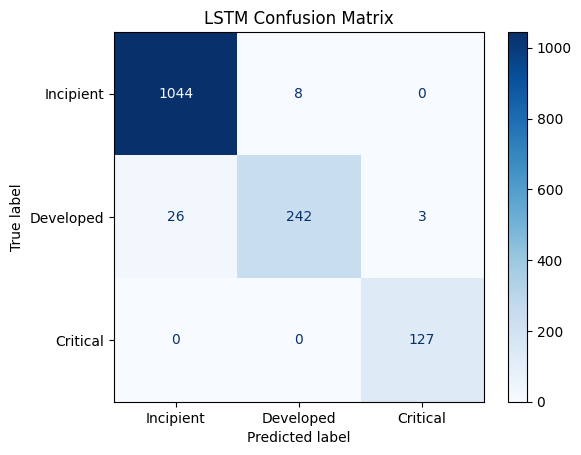

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Chạy inference trên tập test
model.eval()
test_loss, y_true, y_pred = run_epoch(test_loader, train=False)

# In kết quả
print("\n=== 🔥 KẾT QUẢ TEST (LSTM) ===")
print(f"Test Loss: {test_loss:.4f}")
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Incipient', 'Developed', 'Critical'], digits=3))

# Hiển thị confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Incipient', 'Developed', 'Critical'])
disp.plot(cmap='Blues', values_format='d')
plt.title("LSTM Confusion Matrix")
plt.show()


In [8]:
def predict_sequence(seq_feats: np.ndarray):
    model.eval()
    x = torch.tensor(seq_feats, dtype=torch.float32).unsqueeze(0).to(DEVICE)  # [1, SEQ_LEN, 4]
    with torch.no_grad():
        out = model(x)
    pred_label = out.argmax(1).item()
    label_map = ['Incipient', 'Developed', 'Critical']
    return pred_label, label_map[pred_label]

# Ví dụ với 1 sequence giả
fake_seq = np.array([
    [0.01, 0.5, 0.5, 1.0],
    [0.015, 0.51, 0.49, 1.1],
    [0.018, 0.52, 0.48, 1.2],
    [0.022, 0.53, 0.47, 1.3],
    [0.030, 0.54, 0.46, 1.4]
], dtype=np.float32)

label_id, label_name = predict_sequence(fake_seq)
print(f"🔥 Predicted Fire Spread Level: {label_name} (class {label_id})")

🔥 Predicted Fire Spread Level: Developed (class 1)


In [9]:
from pathlib import Path
import cv2
import numpy as np
from ultralytics import YOLO
import torch

# ===========================
# SETTINGS
# ===========================
IMG_SIZE = 320
SEQ_LEN = 5
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
AREA_THRESH = (0.02, 0.15)

# Load model
model_lstm = SpreadLSTM().to(DEVICE)
model_lstm.load_state_dict(best_state)  # từ đoạn train trước đó
model_lstm.eval()

# Load detector
yolo_det = YOLO('fire_det_best.pt')

# ===========================
# Function: extract features from an image
# ===========================
def extract_feature(img_path):
    res = yolo_det.predict(str(img_path), conf=0.25, imgsz=IMG_SIZE, verbose=False)[0]
    h, w = res.orig_shape

    fire_boxes = [b for b,cls in zip(res.boxes.xyxy.cpu().numpy(), res.boxes.cls.cpu().numpy()) if cls == 0]
    if fire_boxes:
        x1, y1, x2, y2 = max(fire_boxes, key=lambda b: (b[2]-b[0]) * (b[3]-b[1]))
        area = (x2 - x1) * (y2 - y1)
        cx, cy = (x1 + x2) / 2, (y1 + y2) / 2
        ar = (x2 - x1) / (y2 - y1 + 1e-6)
    else:
        area = cx = cy = ar = 0.0

    return [
        area / (w * h),  # area_norm
        cx / w,          # cx_norm
        cy / h,          # cy_norm
        ar               # aspect_ratio
    ]

# ===========================
# Function: predict from a folder of images
# ===========================
def predict_folder(folder_path):
    img_paths = sorted(Path(folder_path).rglob('*.[jp][pn]g'))[:50]  # lấy tối đa 50 ảnh
    features = [extract_feature(p) for p in img_paths]

    if len(features) < SEQ_LEN:
        print("⚠️ Not enough frames to make a prediction.")
        return

    label_map = ['Incipient', 'Developed', 'Critical']
    for i in range(len(features) - SEQ_LEN + 1):
        seq = np.array(features[i:i+SEQ_LEN], dtype=np.float32)
        x = torch.tensor(seq).unsqueeze(0).to(DEVICE)  # [1, SEQ_LEN, 4]
        with torch.no_grad():
            out = model_lstm(x)
        pred = out.argmax(1).item()
        print(f"🧪 Sequence {i+1:02d}: Prediction = {label_map[pred]} (class {pred})")

# ===========================
# RUN DEMO
# ===========================
predict_folder("/kaggle/working/fire_dataset/fire_smoke/test/images")


🧪 Sequence 01: Prediction = Incipient (class 0)
🧪 Sequence 02: Prediction = Incipient (class 0)
🧪 Sequence 03: Prediction = Incipient (class 0)
🧪 Sequence 04: Prediction = Incipient (class 0)
🧪 Sequence 05: Prediction = Incipient (class 0)
🧪 Sequence 06: Prediction = Incipient (class 0)
🧪 Sequence 07: Prediction = Incipient (class 0)
🧪 Sequence 08: Prediction = Incipient (class 0)
🧪 Sequence 09: Prediction = Incipient (class 0)
🧪 Sequence 10: Prediction = Critical (class 2)
🧪 Sequence 11: Prediction = Developed (class 1)
🧪 Sequence 12: Prediction = Incipient (class 0)
🧪 Sequence 13: Prediction = Critical (class 2)
🧪 Sequence 14: Prediction = Incipient (class 0)
🧪 Sequence 15: Prediction = Incipient (class 0)
🧪 Sequence 16: Prediction = Incipient (class 0)
🧪 Sequence 17: Prediction = Critical (class 2)
🧪 Sequence 18: Prediction = Critical (class 2)
🧪 Sequence 19: Prediction = Critical (class 2)
🧪 Sequence 20: Prediction = Critical (class 2)
🧪 Sequence 21: Prediction = Incipient (class 0

In [10]:
from pathlib import Path
import random

# Tự động lấy 100 ảnh từ tập train YOLOv8 để dùng làm calibration dataset cho quantization TFLite
def generate_calibration_image_list(img_dirs, max_imgs=100):
    all_imgs = []
    for d in img_dirs:
        all_imgs += list(Path(d).rglob('*.[jp][pn]g'))
    random.seed(0)
    random.shuffle(all_imgs)
    return all_imgs[:max_imgs]

# Thư mục ảnh đã dùng để train YOLOv8 detector
img_dirs = [
    "fire_dataset/fire_only/train/images",
    "fire_dataset/fire_smoke/train/images",
    "fire_dataset/smoke_fire/train/images"
]

sample_imgs = generate_calibration_image_list(img_dirs, max_imgs=100)
import pandas as pd
import pandas as pd
pd.DataFrame({"images": sample_imgs}).head(20)  # hiển thị 20 ảnh đầu tiên


,images
0,fire_dataset/fire_smoke/train/images/output_06...
1,fire_dataset/fire_smoke/train/images/Img_1022_...
2,fire_dataset/fire_smoke/train/images/bb0301_jp...
3,fire_dataset/fire_smoke/train/images/case2_hou...
4,fire_dataset/smoke_fire/train/images/AoF04618.jpg
5,fire_dataset/fire_smoke/train/images/bb0625_jp...
6,fire_dataset/smoke_fire/train/images/WEB07884.jpg
7,fire_dataset/fire_smoke/train/images/IMG_5679_...
8,fire_dataset/smoke_fire/train/images/WEB06504.jpg
9,fire_dataset/smoke_fire/train/images/WEB01687.jpg


In [11]:
from ultralytics import YOLO

model = YOLO("fire_det_best.pt")  # hoặc fire_cls_best.pt
model.export(format="saved_model", imgsz=320)  # tạo thư mục runs/...


Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'fire_det_best.pt' with input shape (1, 3, 320, 320) BCHW and output shape(s) (1, 5, 2100) (5.9 MB)


E0000 00:00:1752156110.912175      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752156111.013761      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


requirements: Ultralytics requirements ['sng4onnx>=1.0.1', 'onnx_graphsurgeon>=0.3.26', 'ai-edge-litert>=1.2.0,<1.4.0', 'onnx2tf>=1.26.3', 'protobuf>=5'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 2.9s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


TensorFlow SavedModel: starting export with tensorflow 2.18.0...


100%|██████████| 1.11M/1.11M [00:00<00:00, 23.8MB/s]
Unzipping calibration_image_sample_data_20x128x128x3_float32.npy.zip to /kaggle/working/calibration_image_sample_data_20x128x128x3_float32.npy...: 100%|██████████| 1/1 [00:00<00:00, 49.70file/s]


ONNX: starting export with onnx 1.17.0 opset 19...


ONNX: slimming with onnxslim 0.1.59...
ONNX: export success ✅ 1.5s, saved as 'fire_det_best.onnx' (11.6 MB)
TensorFlow SavedModel: starting TFLite export with onnx2tf 1.28.1...


I0000 00:00:1752156131.994551      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13154 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752156131.995348      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
E0000 00:00:1752156137.167031      19 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
E0000 00:00:1752156137.863269      19 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs t

Saved artifact at 'fire_det_best_saved_model'. The following endpoints are available:

* Endpoint 'serving_default'
  inputs_0 (POSITIONAL_ONLY): TensorSpec(shape=(1, 320, 320, 3), dtype=tf.float32, name='images')
Output Type:
  TensorSpec(shape=(1, 5, 2100), dtype=tf.float32, name=None)
Captures:
  139483390502736: TensorSpec(shape=(4, 2), dtype=tf.int32, name=None)
  139483390502352: TensorSpec(shape=(3, 3, 3, 16), dtype=tf.float32, name=None)
  139483390503120: TensorSpec(shape=(16,), dtype=tf.float32, name=None)
  139483390506384: TensorSpec(shape=(4, 2), dtype=tf.int32, name=None)
  139483390506000: TensorSpec(shape=(3, 3, 16, 32), dtype=tf.float32, name=None)
  139483390506960: TensorSpec(shape=(32,), dtype=tf.float32, name=None)
  139483390504848: TensorSpec(shape=(1, 1, 32, 32), dtype=tf.float32, name=None)
  139483390507344: TensorSpec(shape=(32,), dtype=tf.float32, name=None)
  139483390507920: TensorSpec(shape=(4,), dtype=tf.int64, name=None)
  139483390507728: TensorSpec(sh

I0000 00:00:1752156144.887149      19 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 2
I0000 00:00:1752156144.887320      19 single_machine.cc:361] Starting new session
I0000 00:00:1752156144.889425      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13154 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752156144.889624      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
W0000 00:00:1752156146.951481      19 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1752156146.951519      19 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1752156148.156314      19 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 2
I0000 00:00:1752156148.156

TensorFlow SavedModel: export success ✅ 43.5s, saved as 'fire_det_best_saved_model' (29.2 MB)

Export complete (43.7s)
Results saved to /kaggle/working
Predict:         yolo predict task=detect model=fire_det_best_saved_model imgsz=320  
Validate:        yolo val task=detect model=fire_det_best_saved_model imgsz=320 data=data_fire.yaml  
Visualize:       https://netron.app


'fire_det_best_saved_model'

In [12]:
# rep_dataset + TFLite quantization trong 1 cell

import numpy as np
import cv2
from pathlib import Path
import tensorflow as tf

# ✅ Hàm chuẩn hóa ảnh để dùng trong quantization
def representative_dataset_gen(img_dir='fire_dataset', img_size=320, max_imgs=100):
    paths = list(Path(img_dir).rglob('train/images/*.[jp][pn]g'))
    print(f"Found {len(paths)} images.")
    paths = paths[:max_imgs]
    for p in paths:
        img = cv2.imread(str(p))
        if img is None:
            continue
        img = cv2.resize(img, (img_size, img_size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.0
        img = np.expand_dims(img, axis=0)  # [1, H, W, C]
        yield [img]

# ✅ Load SavedModel từ YOLOv8 export
converter = tf.lite.TFLiteConverter.from_saved_model("fire_det_best_saved_model")


# ✅ Bật quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = lambda: representative_dataset_gen("fire_dataset")

# ✅ INT8 full inference
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

# ✅ Chuyển đổi và ghi file
tflite_quant_model = converter.convert()

with open("fire_det_quant.tflite", "wb") as f:
    f.write(tflite_quant_model)

print("✅ Xuất file fire_det_quant.tflite thành công.")


W0000 00:00:1752156173.434237      19 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1752156173.434266      19 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1752156173.482084      19 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


Found 10164 images.


fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


✅ Xuất file fire_det_quant.tflite thành công.
